In [ ]:
# Load packages
import pandas as pd
import importlib
import eda_functions
importlib.reload(eda_functions)
import eda_functions as eda

In [32]:
# Load datasets
engagement_df = pd.read_csv("../data/processed/engagement_details.csv")
campaign_df = pd.read_csv("../data/processed/campaigns.csv")
customer_df = pd.read_csv("../data/processed/customer.csv")
digital_usage_df = pd.read_csv("../data/processed/digital_usage.csv")
products_owned_df = pd.read_csv("../data/processed/products_owned.csv")
transactions_df = pd.read_csv("../data/processed/transactions.csv")

In [33]:
# Keep only relevant features

# Convert to datetime format
transactions_df['transaction_date'] = pd.to_datetime( 
    transactions_df['transaction_date'], format="%Y-%m-%d %H:%M:%S")
digital_usage_df['last_mobile_use'] = pd.to_datetime( 
    digital_usage_df['last_mobile_use'], format="%Y-%m-%d")
digital_usage_df['last_web_use'] = pd.to_datetime( 
    digital_usage_df['last_web_use'], format="%Y-%m-%d")

# Get most recent transaction per customer
last_transaction_df = transactions_df.groupby('customer_id', as_index=False)['transaction_date'].max()
last_transaction_df = last_transaction_df.rename(columns={'transaction_date': 'last_transaction_date'})

# Convert date fields to days since xxx format
reference_date = pd.to_datetime('2025-01-01')
transactions_df['days_since_transaction'] = (reference_date - transactions_df['transaction_date']).dt.days
digital_usage_df['days_since_mobile_use'] = (reference_date - digital_usage_df['last_mobile_use']).dt.days
digital_usage_df['days_since_web_use'] = (reference_date - digital_usage_df['last_web_use']).dt.days

# Drop original datetime columns
transactions_df = transactions_df.drop(columns=['transaction_date'])
digital_usage_df = digital_usage_df.drop(columns=['last_mobile_use', 'last_web_use'])

engagement_df = engagement_df[[ 'customer_id', 'campaign_id', 'channel_used', 'has_engaged']]
campaign_df = campaign_df[[ 'campaign_id', 'campaign_type', 'campaign_duration', 
                            'campaign_language', 'impressions', 'clicks']]
customer_df = customer_df.drop(columns='default')

In [34]:
# Get percentage of null values in column last_transaction_date
test_df = engagement_df.merge(last_transaction_df, on='customer_id', how='left')
null_percentages_test= test_df.isnull().mean().round(4) * 100
null_percentages_test = null_percentages_test.sort_values(ascending=False)
print(null_percentages_test)

# Filter rows with missing values
missing_rows_df = test_df[test_df['last_transaction_date'].isnull()]

# Count occurrences of 0 and 1 for has_engaged in missing data
has_engaged_counts = missing_rows_df['has_engaged'].value_counts()
print(has_engaged_counts)

# Calculate percentages
has_engaged_percentages = has_engaged_counts / len(missing_rows_df) * 100
print(has_engaged_percentages)

last_transaction_date    54.19
customer_id               0.00
campaign_id               0.00
channel_used              0.00
has_engaged               0.00
dtype: float64
has_engaged
0    6734
1    1937
Name: count, dtype: int64
has_engaged
0    77.661169
1    22.338831
Name: count, dtype: float64


In [35]:
# Merge files
combined_df = engagement_df.merge(campaign_df, on='campaign_id', how='left')
combined_df = combined_df.merge(customer_df, on='customer_id', how='left')
combined_df = combined_df.merge(digital_usage_df, on='customer_id', how='left')
combined_df = combined_df.merge(products_owned_df, on='customer_id', how='left')
#combined_df = combined_df.merge(last_transaction_df, on='customer_id', how='left')

# Drop ID columns
combined_df = combined_df.drop(columns=['customer_id', 'campaign_id'])

null_percentages = combined_df.isnull().mean().round(4) * 100
null_percentages = null_percentages.sort_values(ascending=False)
print(null_percentages)

days_since_mobile_use      27.76
avg_mobile_time            27.76
mobile_logins_wk           27.76
clicks                     16.14
days_since_web_use         12.76
avg_web_time               12.76
web_logins_wk              12.76
has_web_account             0.53
has_mobile_app              0.53
channel_used                0.00
customer_lifetime_value     0.00
has_fixed_deposit           0.00
has_personal_loan           0.00
has_home_loan               0.00
has_credit_card             0.00
has_investment_product      0.00
dependents                  0.00
has_engaged                 0.00
nps                         0.00
tenure                      0.00
income                      0.00
debt                        0.00
balance                     0.00
education                   0.00
marital                     0.00
job                         0.00
age                         0.00
impressions                 0.00
campaign_language           0.00
campaign_duration           0.00
campaign_t

In [36]:
# Check missing mobile logins correlation with has_mobile_app
print(eda.check_missing_correlation(combined_df, 'mobile_logins_wk', 'has_mobile_app'))

# Check missing web logins correlation with has_web_account
print(eda.check_missing_correlation(combined_df, 'web_logins_wk', 'has_web_account'))

# Check missing avg_mobile_time correlation with has_mobile_app
print(eda.check_missing_correlation(combined_df, 'avg_mobile_time', 'has_mobile_app'))

# Check missing avg_web_time correlation with has_web_account
print(eda.check_missing_correlation(combined_df, 'avg_web_time', 'has_web_account'))

# Check missing days_since_mobile_use correlation with has_mobile_app
print(eda.check_missing_correlation(combined_df, 'days_since_mobile_use', 'has_mobile_app'))

# Check missing days_since_web_use correlation with has_web_account
print(eda.check_missing_correlation(combined_df, 'days_since_web_use', 'has_web_account'))


Total missing values in 'mobile_logins_wk': 4464
has_mobile_app
0.0    4378
Name: count, dtype: int64
Total missing values in 'web_logins_wk': 2052
has_web_account
0.0    1966
Name: count, dtype: int64
Total missing values in 'avg_mobile_time': 4464
has_mobile_app
0.0    4378
Name: count, dtype: int64
Total missing values in 'avg_web_time': 2052
has_web_account
0.0    1966
Name: count, dtype: int64
Total missing values in 'days_since_mobile_use': 4464
has_mobile_app
0.0    4378
Name: count, dtype: int64
Total missing values in 'days_since_web_use': 2052
has_web_account
0.0    1966
Name: count, dtype: int64


In [37]:
# Drop rows where has_mobile_app or has_web_account is NaN
combined_df = combined_df.dropna(subset=['has_mobile_app', 'has_web_account'])

# Fill NaNs with 0 for digital activity columns
cols_to_fill_zero = ['mobile_logins_wk', 'web_logins_wk', 'avg_mobile_time', 'avg_web_time', 'clicks']
combined_df[cols_to_fill_zero] = combined_df[cols_to_fill_zero].fillna(0)

# Assign a large number to indicate extreme inactivity
combined_df['days_since_mobile_use'] = combined_df['days_since_mobile_use'].fillna(9999)
combined_df['days_since_web_use'] = combined_df['days_since_web_use'].fillna(9999)

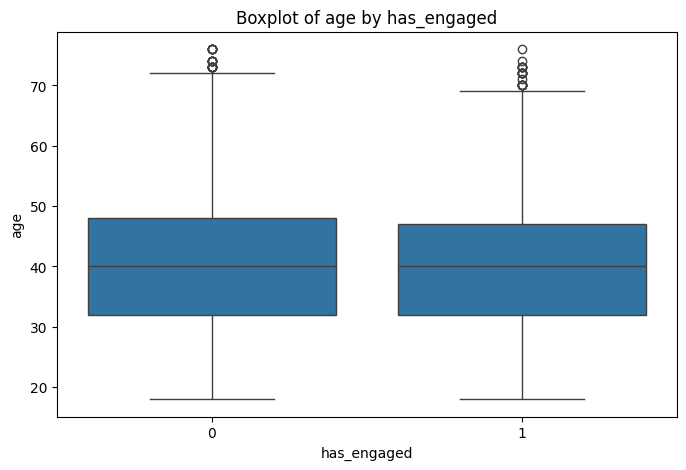

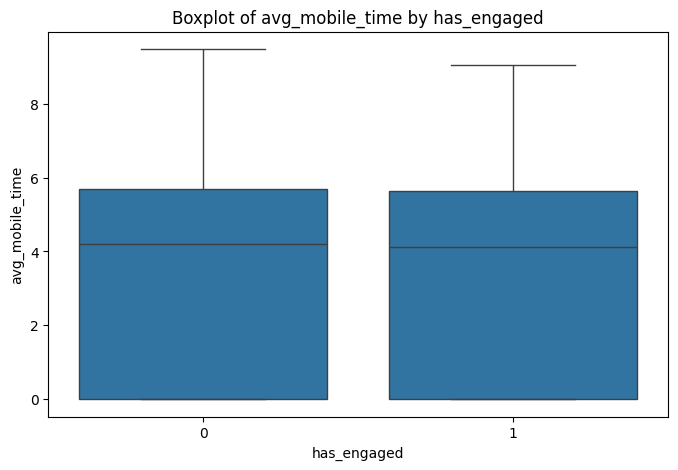

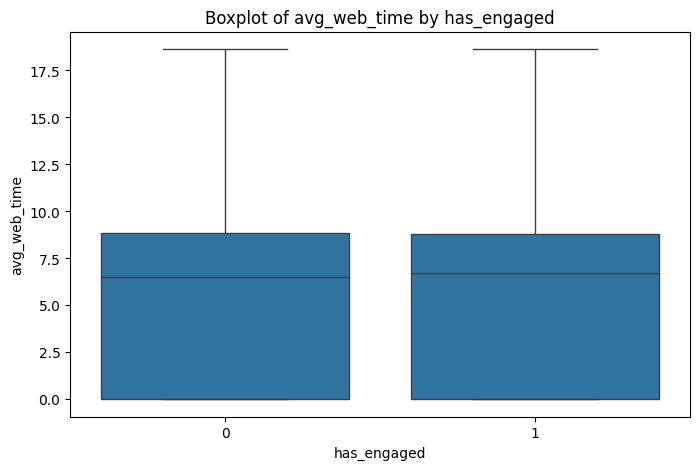

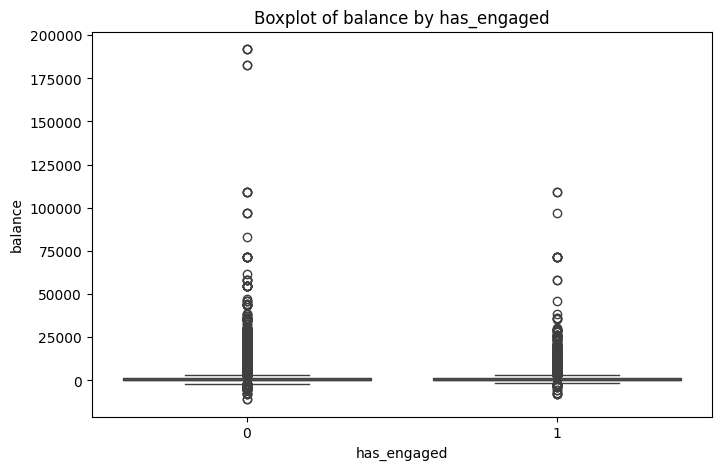

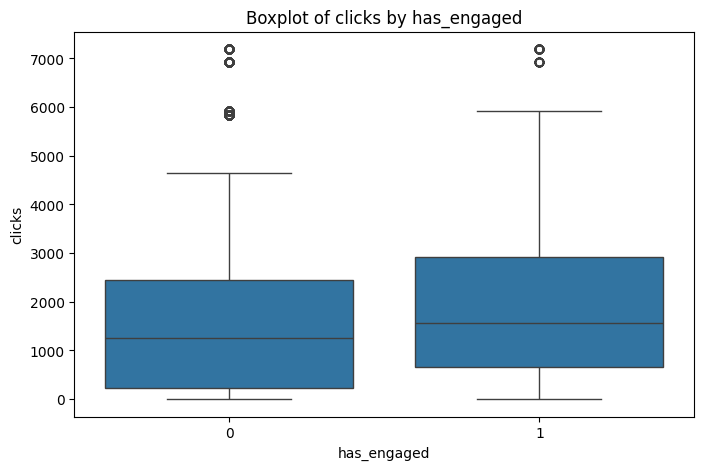

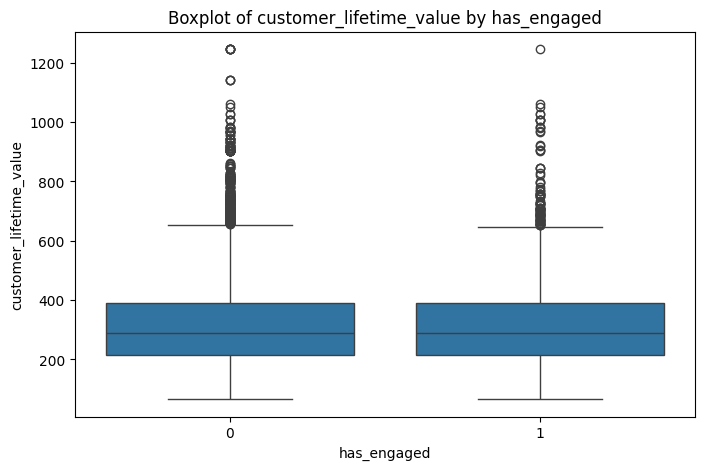

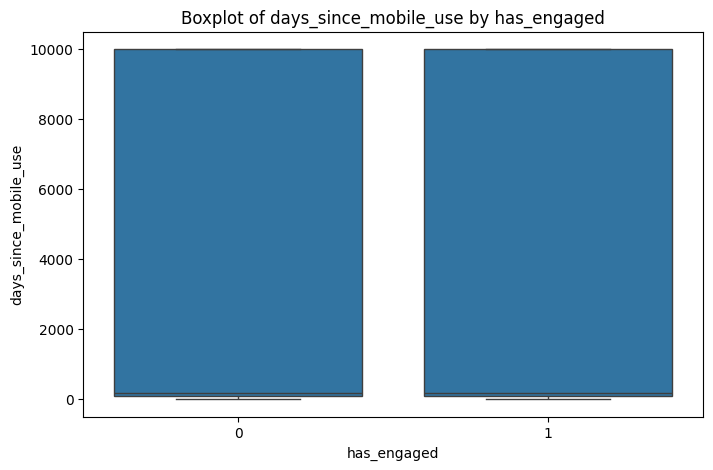

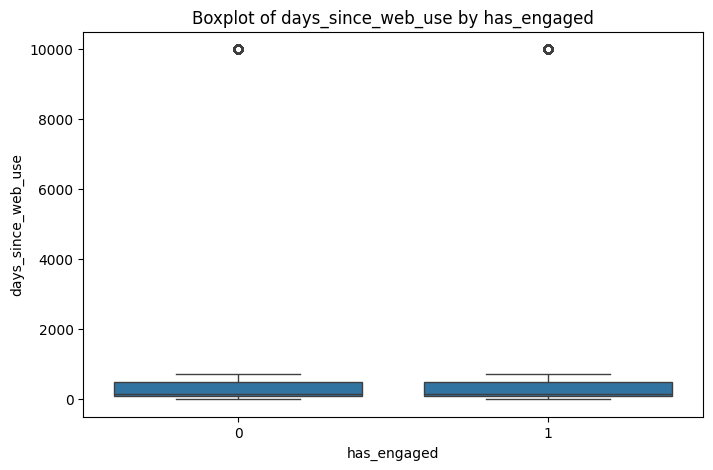

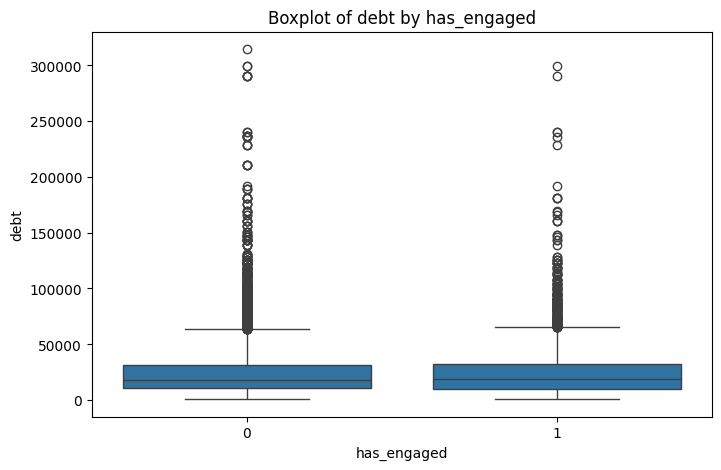

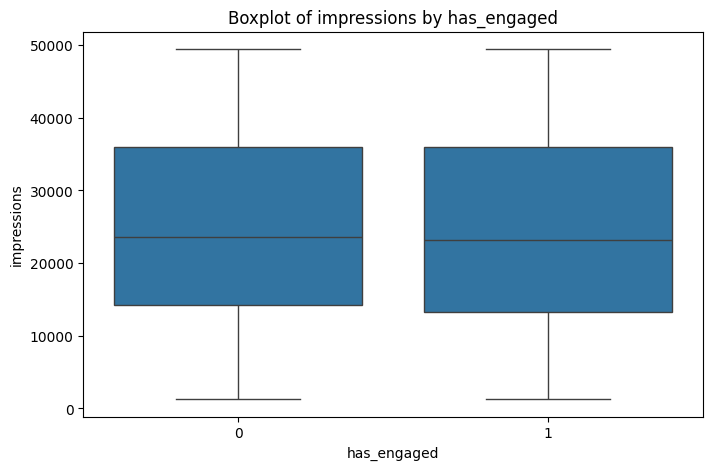

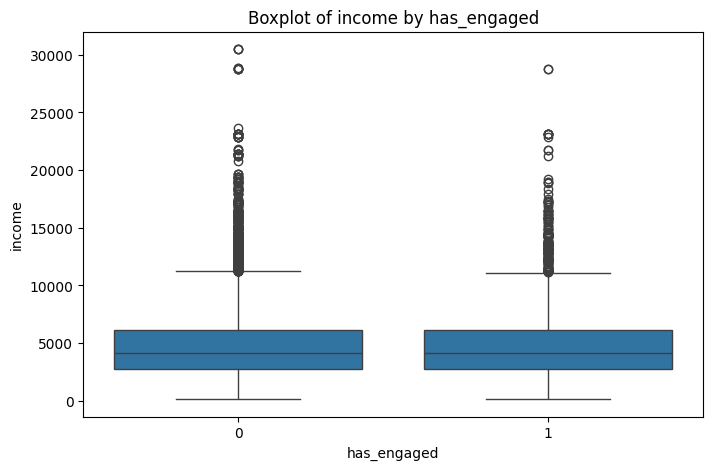

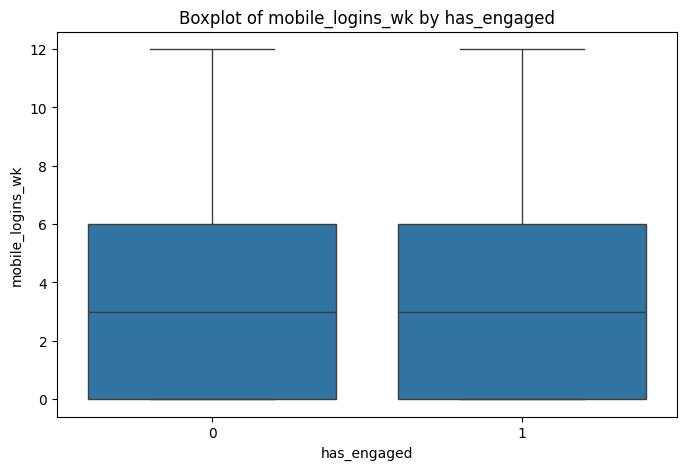

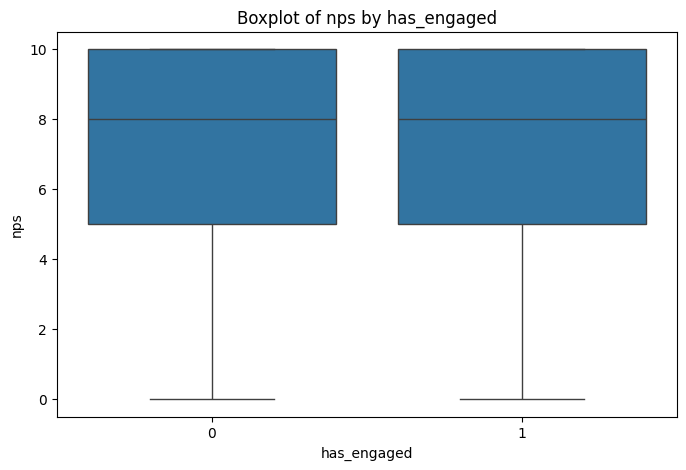

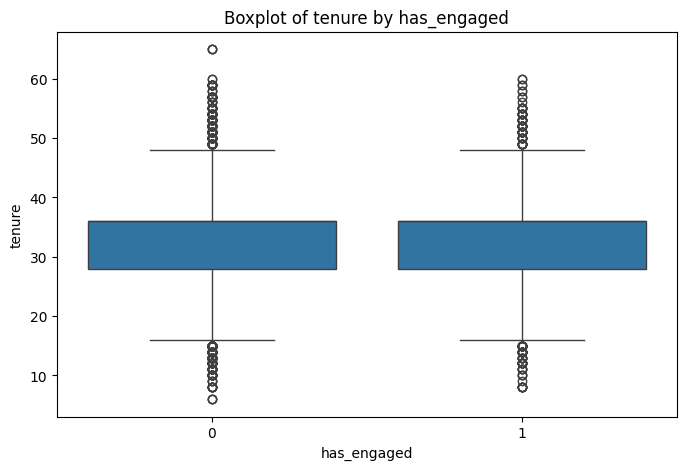

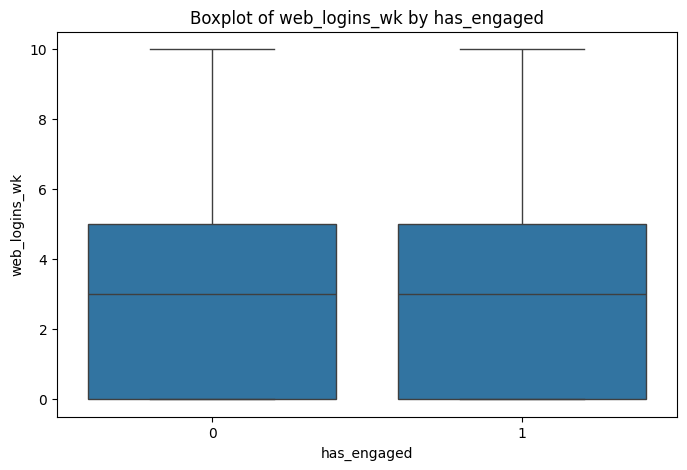

In [38]:
# Set df and target column
df = combined_df.copy()
target_col = 'has_engaged'

# 1. Boxplots for numerical variables by engagement
eda.get_boxplot(df, target_col)

In [39]:
# 2. T-tests for numerical variables
ttest_results = eda.get_ttest(df, target_col)
print("T-test Results:\n", ttest_results)

T-test Results:
                     Feature  T-Statistic       P-Value
4                    clicks   -13.208949  3.011794e-39
9               impressions    -2.165657  3.037909e-02
0                       age     1.674776  9.403179e-02
13                   tenure     1.316577  1.880327e-01
11         mobile_logins_wk    -0.906367  3.647797e-01
7        days_since_web_use    -0.817605  4.136172e-01
8                      debt    -0.722635  4.699342e-01
2              avg_web_time    -0.582008  5.605844e-01
14            web_logins_wk     0.419307  6.750074e-01
1           avg_mobile_time     0.324348  7.456865e-01
10                   income    -0.223745  8.229635e-01
6     days_since_mobile_use     0.210178  8.335359e-01
5   customer_lifetime_value    -0.160601  8.724134e-01
12                      nps    -0.106578  9.151272e-01
3                   balance     0.106347  9.153108e-01


In [40]:
# 3. Identify categorical columns (excluding the target)
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += [col for col in df.columns 
             if df[col].dropna().nunique() <= 10 and 
             df[col].dtype in ['int64', 'float64'] and col != target_col]

cat_cols = list(set(cat_cols) - {target_col})


Proportion Table for job:
has_engaged           0         1
job                              
admin.         0.781046  0.218954
blue-collar    0.765398  0.234602
entrepreneur   0.773793  0.226207
housemaid      0.790517  0.209483
management     0.766243  0.233757
retired        0.782609  0.217391
self-employed  0.784493  0.215507
services       0.772727  0.227273
student        0.792135  0.207865
technician     0.780522  0.219478
unemployed     0.776660  0.223340
unknown        0.779330  0.220670


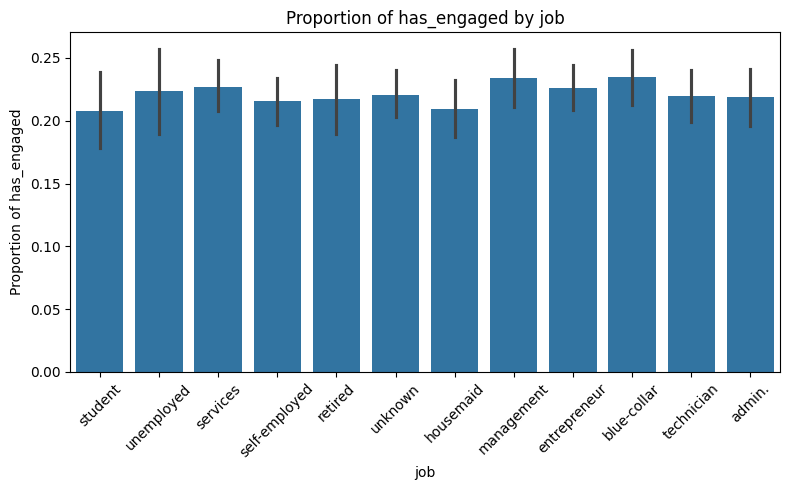


Proportion Table for has_web_account:
has_engaged             0         1
has_web_account                    
0.0              0.770092  0.229908
1.0              0.778911  0.221089


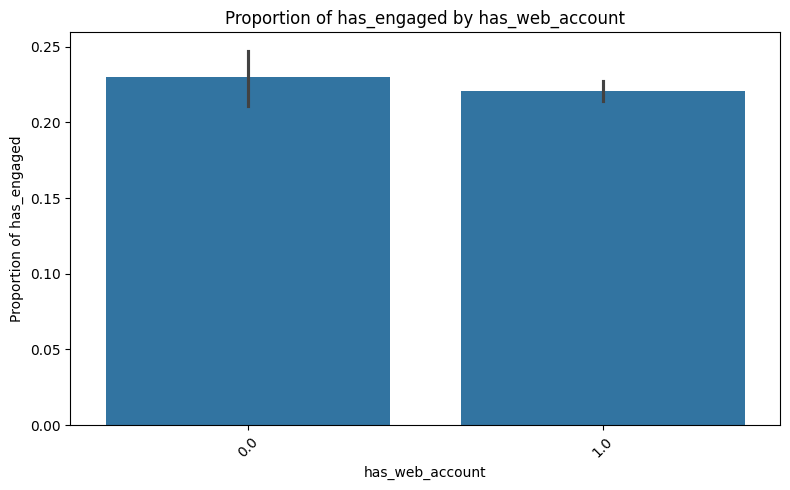


Proportion Table for has_home_loan:
has_engaged           0         1
has_home_loan                    
0              0.778024  0.221976
1              0.772947  0.227053


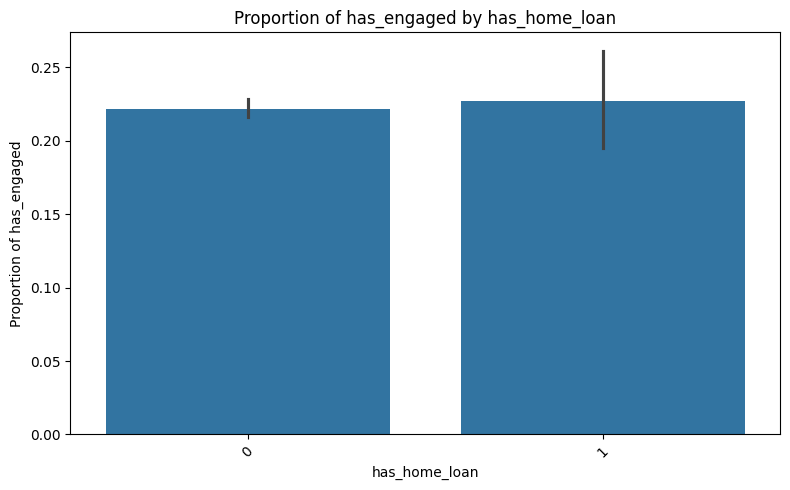


Proportion Table for has_investment_product:
has_engaged                    0         1
has_investment_product                    
0                       0.775651  0.224349
1                       0.784174  0.215826


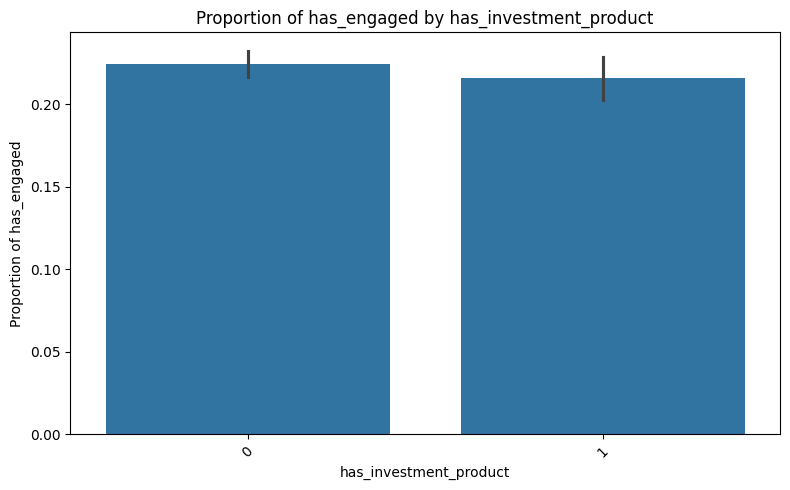


Proportion Table for has_credit_card:
has_engaged             0         1
has_credit_card                    
0                0.775744  0.224256
1                0.778722  0.221278


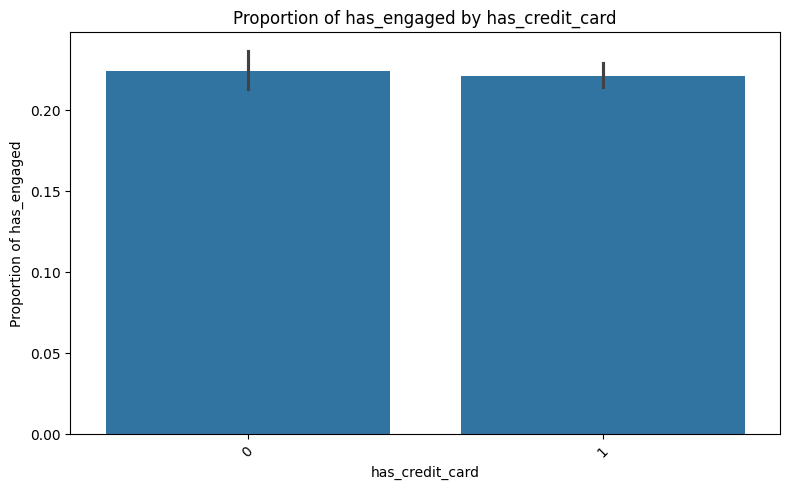


Proportion Table for education:
has_engaged         0         1
education                      
primary      0.768373  0.231627
secondary    0.778577  0.221423
tertiary     0.783854  0.216146
unknown      0.762170  0.237830


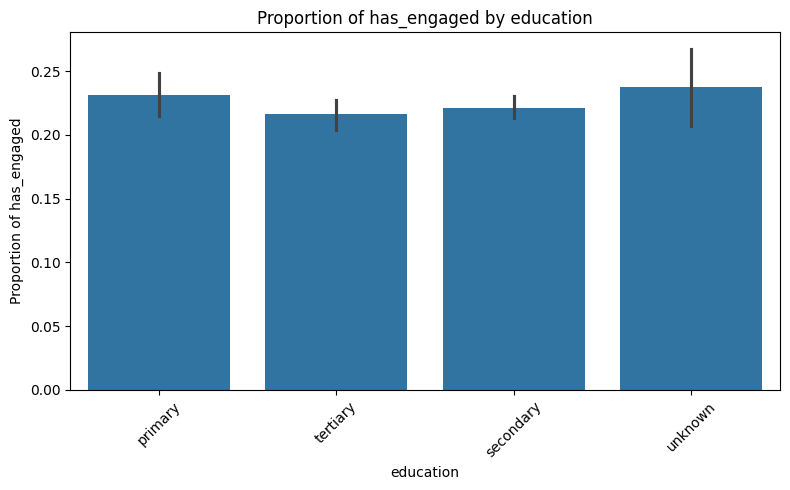


Proportion Table for campaign_language:
has_engaged               0         1
campaign_language                    
English            0.748645  0.251355
French             0.768748  0.231252
German             0.781122  0.218878
Mandarin           0.804052  0.195948
Spanish            0.765172  0.234828


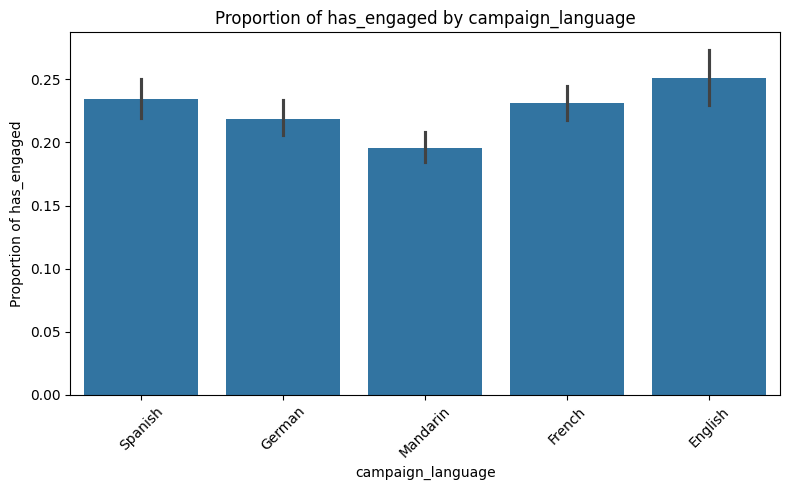


Proportion Table for marital:
has_engaged         0         1
marital                        
divorced     0.771970  0.228030
married      0.779729  0.220271
single       0.776324  0.223676


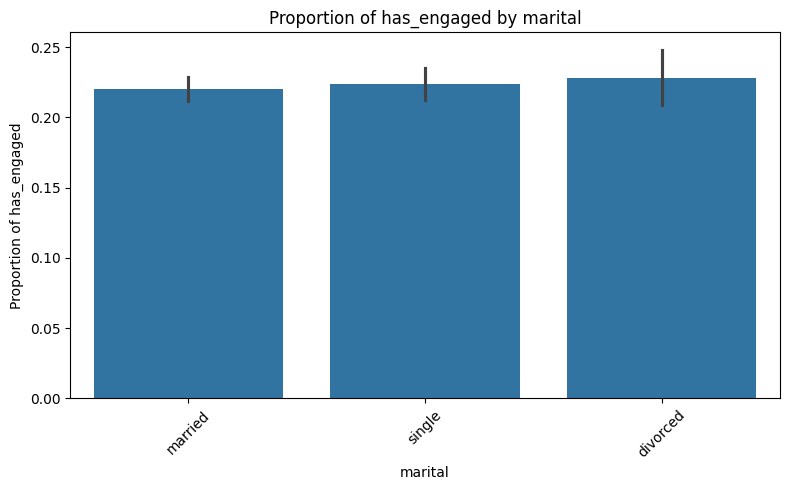


Proportion Table for has_fixed_deposit:
has_engaged               0         1
has_fixed_deposit                    
0                  0.777261  0.222739
1                  0.779988  0.220012


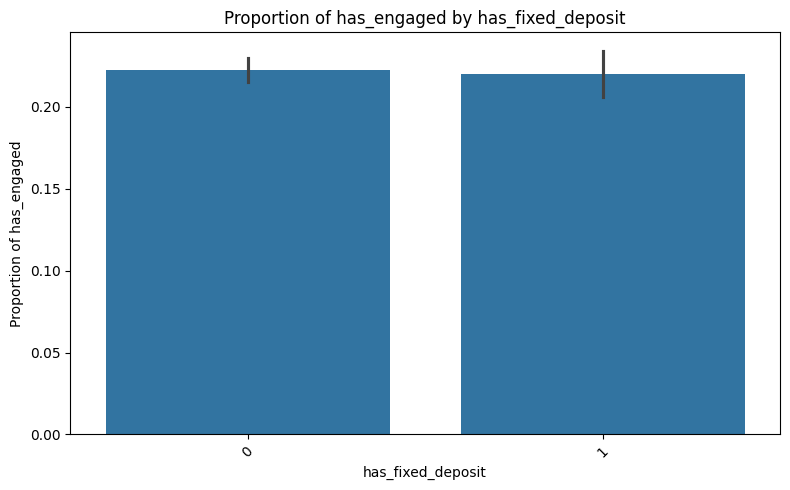


Proportion Table for channel_used:
has_engaged          0         1
channel_used                    
Email         0.804408  0.195592
Google Ads    0.843565  0.156435
Instagram     0.650000  0.350000
Landline      0.974961  0.025039
Telephone     0.947126  0.052874
TikTok        0.588743  0.411257
Website       0.904047  0.095953


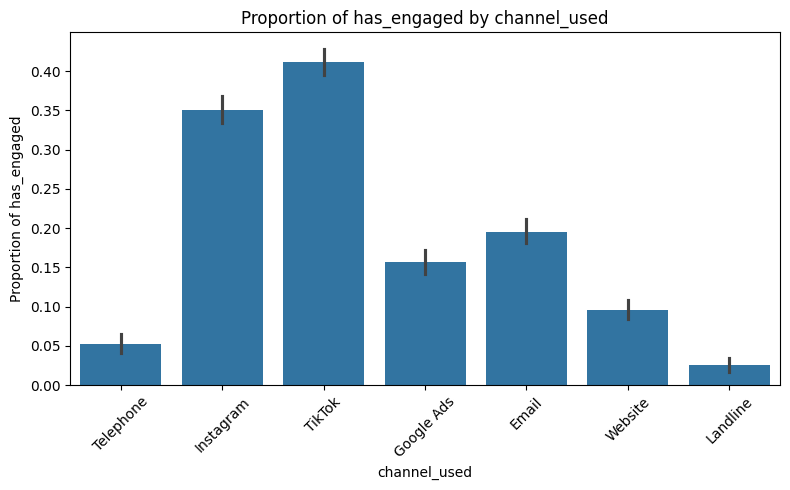


Proportion Table for campaign_type:
has_engaged                        0         1
campaign_type                                 
Affiliate Marketing         0.606016  0.393984
Display Advertising         0.753118  0.246882
Email Marketing             0.804408  0.195592
Search Engine Optimization  0.838449  0.161551
Telemarketing               0.960898  0.039102


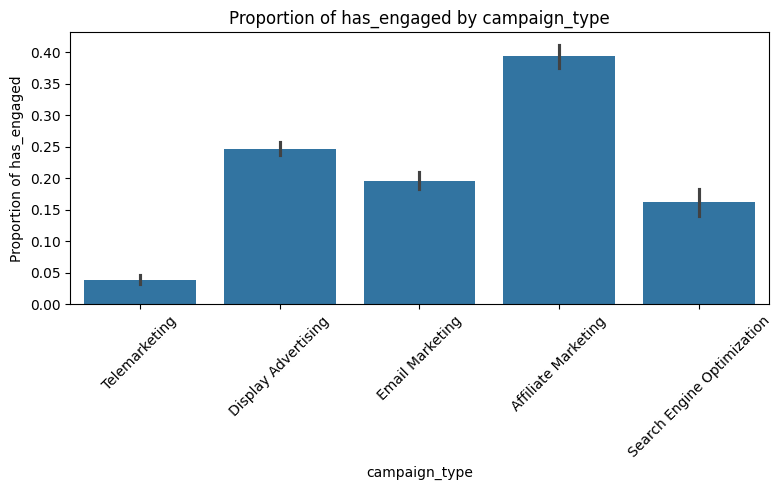


Proportion Table for has_personal_loan:
has_engaged               0         1
has_personal_loan                    
0                  0.776726  0.223274
1                  0.780657  0.219343


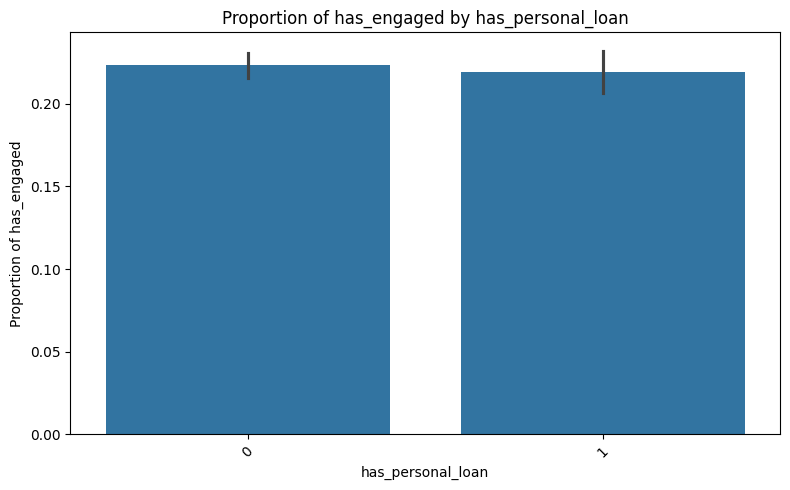


Proportion Table for campaign_duration:
has_engaged               0         1
campaign_duration                    
15                 0.762643  0.237357
30                 0.810578  0.189422
45                 0.829898  0.170102
60                 0.753809  0.246191
75                 0.740088  0.259912


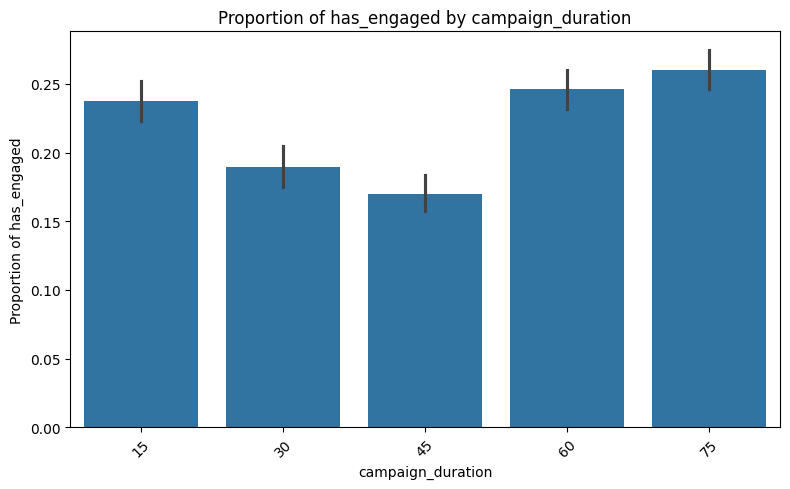


Proportion Table for dependents:
has_engaged         0         1
dependents                     
0            0.778788  0.221212
1            0.770025  0.229975
2            0.776746  0.223254
3            0.777964  0.222036
4            0.782468  0.217532
5            0.799663  0.200337


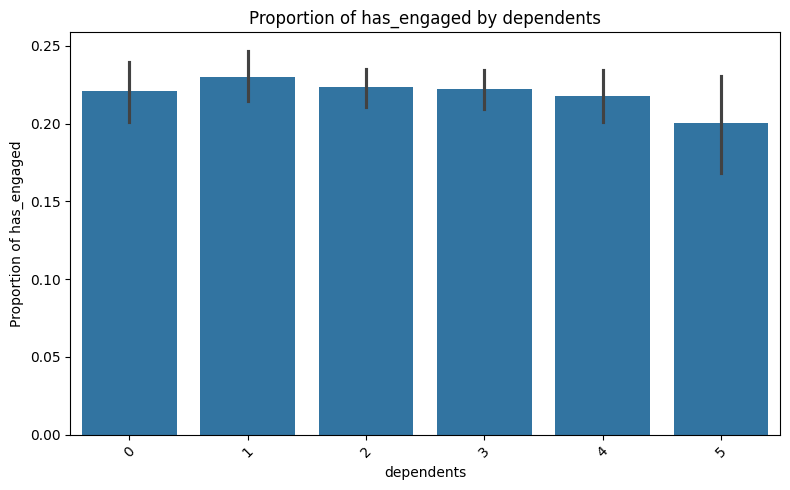


Proportion Table for has_mobile_app:
has_engaged            0         1
has_mobile_app                    
0.0             0.778894  0.221106
1.0             0.777424  0.222576


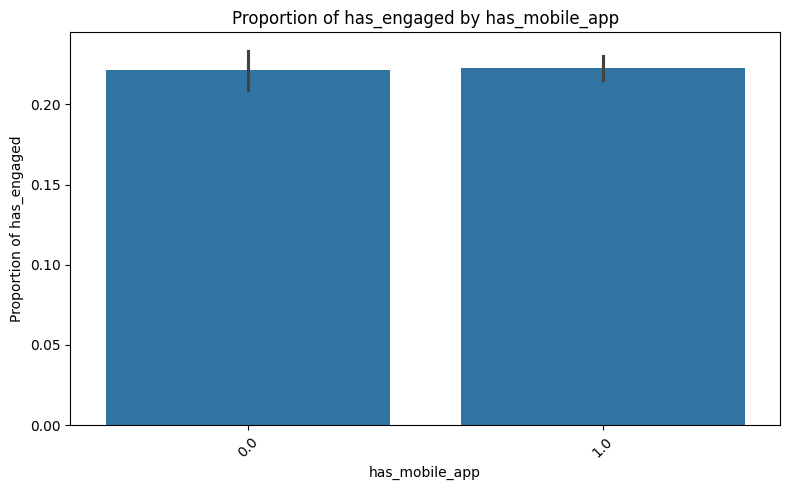


Proportion Table for has_insurance:
has_engaged           0         1
has_insurance                    
0              0.774106  0.225894
1              0.786059  0.213941


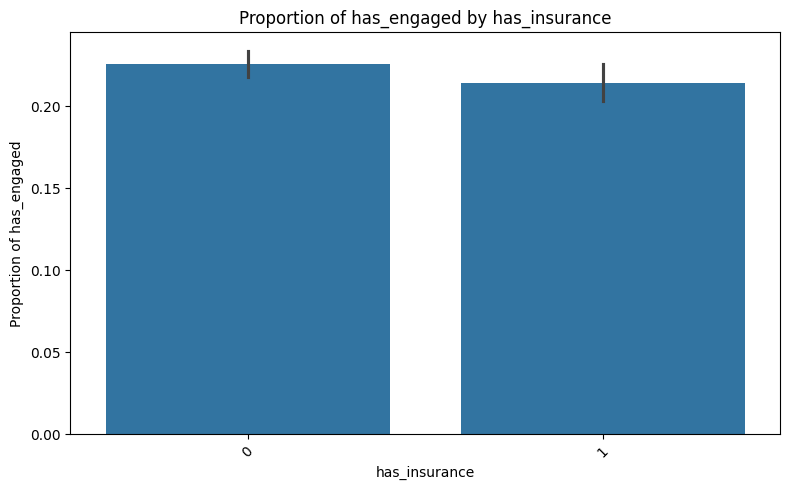

In [41]:
# 4. Proportion tables & bar plots
for col in cat_cols:
    print(f"\nProportion Table for {col}:")
    print(eda.get_proportion_table(df, col, target_col))
    
    eda.get_barplot(df, col, target_col)

In [42]:
# 5. Chi-square test results
chi2_results = eda.get_chi_square(df, cat_cols, target_col)
print("\nChi-Square Test Results:\n", chi2_results)


Chi-Square Test Results:
                    Feature   Chi-Square        P-Value
9             channel_used  1702.128211   0.000000e+00
10           campaign_type  1022.376977  5.047660e-220
12       campaign_duration   112.773216   1.863879e-23
6        campaign_language    28.260145   1.104660e-05
15           has_insurance     2.765739   9.630221e-02
3   has_investment_product     1.229251   2.675528e-01
5                education     3.275484   3.510694e-01
1          has_web_account     0.725843   3.942341e-01
11       has_personal_loan     0.265913   6.060866e-01
4          has_credit_card     0.155712   6.931355e-01
13              dependents     2.973857   7.040166e-01
7                  marital     0.604796   7.390440e-01
8        has_fixed_deposit     0.097959   7.542927e-01
2            has_home_loan     0.062065   8.032619e-01
14          has_mobile_app     0.031738   8.586033e-01
0                      job     5.429409   9.086028e-01
